  Blockbuster or art film?
1. Set up a data science project structure in a new git repository in your GitHub account
2. Download the one of the MovieLens datasets from https://grouplens.org/datasets/movielens/
3. Load the data set into panda data frames
4. Formulate one or two ideas on how the combination of ratings and tags by users helps the data set to establish additional value using exploratory data analysis
5. Build one or more clustering models to determine similar movies to recommend using the other ratings and tags of movies by other users as features
6. Document your process and results
7. Commit your notebook, source code, visualizations and other supporting files to the git repository in GitHub

# Project 3 - Clustering
### Author: Jace Kline

### Goal
We shall try to build one or more clustering models to determine similar movies from a dataset containing user ratings and tags.

### Main Objectives
1. Obtain datasets from MovieLens and load them into Pandas
2. Formulate ideas on how the ratings and tags by users can be used to add additional value to the datasets through use of exploratory data analysis
3. Perform feature engineering using above ideas to extract additional value from the datasets
4. Build clustering models to attempt to group similar movies together


In [134]:
# General imports
import sys
sys.path.append('../src/')

import re
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline

## Loading the Data
First, we must load the data into Pandas. There are two separate datasets that we must load:
* 'tags.csv' -> The fields are: userId, movieId, tag, timestamp
* 'movies.csv' -> The fields are: movieId, title, genres

In [135]:
data_dir = '../data/initial/'

# Load the Tags dataset
df_tags = pd.read_csv(data_dir + 'tags.csv')

df_tags.head()

,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [136]:
# Load the Movies dataset
df_movies = pd.read_csv(data_dir + 'movies.csv')

df_movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Feature Engineering Ideas
By observing the above datasets, we can perform some actions that will result in datasets with enhanced clustering potential. These ideas are as follows:
1. Extract the year from the 'title' column and make it into a separate numerical feature
    * We can further group the years into 5 year increments to increase clustering potential
2. Convert the 'genres' column into a vector of boolean (0 or 1) values for each entry
    * There are 18 possible genres
3. Map all entries in the 'tag' column to lowercase to ensure uniformity, then observe statistics on tag usage

### Extracting the year value from the 'title' column
We shall first dissect the 'title' column and split it into the title and the year. This is important because the numerical year value is a tangible feature that we can use in our clustering model.

In [137]:
def extract(capture_group):
    year_regex = '([^(]*)[(]([0-9]{4})[)]'
    def f(row):
        m = re.search(year_regex,row.title)
        if m is not None:
            return (int(m.group(2)) if capture_group == 2 else str(m.group(1)))
        else:
            return np.nan
    return (lambda r: f(r))
 
def extractYear(row):
    return extract(2)(row)
    
def removeYear(row):
    return extract(1)(row)

df_movies['year'] = df_movies.apply(extractYear, axis=1)
df_movies['year'] = df_movies['year'].fillna(df_movies['year'].mean()).astype(np.short)

df_movies['title'] = df_movies.apply(removeYear, axis=1)

df_movies.head()

,movieId,title,genres,year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995
4,5,Father of the Bride Part II,Comedy,1995


### Assigning the 'year' feature to groups based on normalized increments
To increase the clustering potential of the 'year' column, we shall map each year to a more general group based on partitioned increments.

In [138]:
yearcounts = pd.DataFrame(df_movies['year'].value_counts())
yearcounts.reset_index(level=0, inplace=True)
yearcounts.rename(columns={'index' : 'year', 'year' : 'count'}, inplace=True)
yearcounts['year'] = yearcounts['year'].astype('short')
yearcounts.sort_values(['year','count'], ascending=[1,1], inplace=True)
yearcounts.reset_index(level=0, inplace=True)
moviecount = yearcounts['count'].sum()
print("Total movies: {}".format(moviecount))

Total movies: 9742


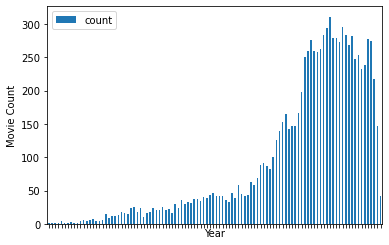

In [139]:
yearcounts.plot.bar(x='year', y='count')
plt.xlabel('Year')
plt.ylabel('Movie Count')
plt.xticks(visible=False)
plt.savefig('../plots/yearcounts.png')
plt.show()

#### Grouping 'year' values - Next steps
Now that we have extracted the total number of movies and viewed the general distribution, we shall group the movies into 6 buckets based on their 'year' attribute.

In [140]:
def yearBins(bins):
    yearbins = []
    bins_left = bins
    movies_left = moviecount
    yr = 0
    counter = 0
    for index, row in yearcounts.iterrows():
        if yr == 0:
            yr = row['year']
        if counter >= (movies_left / bins_left):
            yearbins.append(yr)
            bins_left = bins_left - 1
            movies_left = movies_left - counter
            counter = 0
            yr = row['year'] + 1
        else:
            counter += row['count']
    if len(yearbins) < bins:
        yearbins.append(yr)
    return yearbins
        
print('Year bins: {}'.format(yearBins(6)))

Year bins: [1902, 1982, 1995, 2003, 2010, 2017]


Now that we have our 6 year bins, we shall map the current data to these bins.

In [141]:
def yearBin(bins):
    bs = yearBins(bins)
    def f(row):
        for i in range(0,bins):
            if i == bins - 1:
                return bs[bins - 1]
            elif row['year'] >= bs[i] and row['year'] < bs[i+1]:
                return bs[i]
    return (lambda r: f(r))

df_movies['yearbin'] = df_movies.apply(yearBin(6),axis=1)
df_movies

,movieId,title,genres,year,yearbin
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,1995,1995
1,2,Jumanji,Adventure|Children|Fantasy,1995,1995
2,3,Grumpier Old Men,Comedy|Romance,1995,1995
3,4,Waiting to Exhale,Comedy|Drama|Romance,1995,1995
4,5,Father of the Bride Part II,Comedy,1995,1995
...,...,...,...,...,...
9737,193581,Black Butler: Book of the Atlantic,Action|Animation|Comedy|Fantasy,2017,2017
9738,193583,No Game No Life: Zero,Animation|Comedy|Fantasy,2017,2017
9739,193585,Flint,Drama,2017,2017
9740,193587,Bungo Stray Dogs: Dead Apple,Action|Animation,2018,2017


#### Viewing the bins
As we can see above, the 'year' data has been mapped into our newly created bins in the 'yearbin' column. Below, we plot the new bins and show the movie count in each one. Due to the inability to exactly partition the data, the counts are not perfectly split, but they will work for our purposes. Each bin contains the movies that were released between the shown year and the year of the next bin.

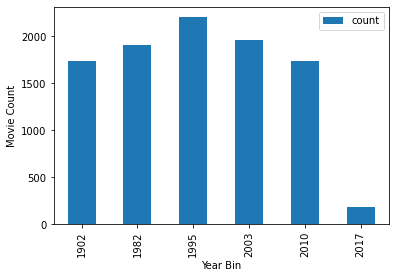

In [142]:
yearbincnts = pd.DataFrame(df_movies['yearbin'].value_counts())
yearbincnts.reset_index(level=0, inplace=True)
yearbincnts.rename(columns={'index' : 'yearbin', 'yearbin' : 'count'}, inplace=True)
yearbincnts['yearbin'] = yearbincnts['yearbin'].astype('short')
yearbincnts.sort_values(['yearbin','count'], ascending=[1,1], inplace=True)
yearbincnts.reset_index(level=0, inplace=True)

yearbincnts.plot.bar(x='yearbin', y='count')
plt.xlabel('Year Bin')
plt.ylabel('Movie Count')
plt.savefig('../plots/yearbins.png')
plt.show()

### Vectorizing the 'genres' column
Since the 'genres' column is inherently a grouping metric, we must convert the data into a form usable by our clustering models. We shall map each 'genres' row entry into an array of 18 boolean (0 or 1) values indicating which genres are present for a particular movie.


#### Vectorizing the 'genres' column
The first step to our transformation of this column shall be to use the SciKit-Learn CountVectorizer class to convert the text field into vectors.

In [143]:
from sklearn.feature_extraction.text import CountVectorizer

In [144]:
genres = ['Action', 'Adventure', 'Animation', 'Children', 'Comedy', 'Crime', 'Documentary', 
          'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi',
          'Thriller', 'War', 'Western']
vectorizer = CountVectorizer( vocabulary=genres, token_pattern='[a-zA-Z\-]+', lowercase=False, binary=True, dtype=np.short )
genres_vector = vectorizer.fit_transform(df_movies['genres'])

#print('Vectorized Genre Data:\n{}'.format(genres_vector.toarray()))
df_genres = pd.DataFrame(data=genres_vector.toarray(), columns=genres, dtype=np.short)
df_genres.head()

,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,0,1,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0
1,0,1,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Adding back the vectorized data
Now that we have vectorized the 'genres' data, we can concatenate it back into the original df_movies dataframe as a new set of features. We can also remove the initial 'genres' column to conserve memory.

In [145]:
df_movies = pd.concat([df_movies, df_genres], axis=1).drop(['genres'],axis=1)
df_movies.head()

,movieId,title,year,yearbin,Action,Adventure,Animation,Children,Comedy,Crime,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story,1995,1995,0,1,1,1,1,0,...,1,0,0,0,0,0,0,0,0,0
1,2,Jumanji,1995,1995,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
2,3,Grumpier Old Men,1995,1995,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,4,Waiting to Exhale,1995,1995,0,0,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,5,Father of the Bride Part II,1995,1995,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


#### Let's save our our modified Movies dataset
Now that we have made some substantial feature engineering changes to our data, let's save it to a new CSV file.

In [146]:
df_movies.to_csv('../data/modified/movies.csv')

### Transforming the Tags dataset
To this point, we have only transformed the Movies dataset. Now, we shall examine and engineer the Tags dataset to better fit our clustering objectives.